In [2]:
!pip install opencv-python matplotlib

In [3]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "/opt/anaconda3/lib/python3.12/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/opt/anaconda3/lib/python3.12/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/opt/anaconda3/lib/python3.12/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^

In [121]:
#standard dependencies
import cv2
import os
import random
import numpy as np#for handling tensors
from matplotlib import pyplot as pito#useful to visualize 2d plots

In [129]:
#tensorflow dependencies
#functional api, siamese nn. oneshot classification(2 images and checks both are same.
#we have 2 imputs, pass 2 images and see the distnace layer for similaritiy between images. If very similar then 1, else output 0

from tensorflow.keras.models import Model#Important layer, when we use function api we pass through Model(where we give inputs and outputs), ex: Model(input=[inputimage, verificationimage] , output=[1,0]). Model
from tensorflow.keras.layers import Layer, Dense, MaxPooling2D, Input, Flatten#Import different layers for our n, inheritance for layers etc. Conv2D(conolutional nn), Dense(fully connected layer), MaxPooling2D(averaging and reducing passing to next layer), Input(define what we pass to model), Flatten(flatten input to 1-D, so convert CNN to dense network)
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import layers

import tensorflow as tf

In [119]:
POS_PATH = os.path.join('data', 'positive')#path setup
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [118]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)#so for each image we have an anchor image(our input image), and we have a positive image(matching to anchor), negative image(not matching to anchor)
#So we need folders for all these, so we use these commands
#To collect our negative images we are going to use world images
#positive, anchor images using webcam

FileExistsError: [Errno 17] File exists: 'data/positive'

In [15]:
#verificiation 1000 feet view
#positive class
#We are going to use an encoding model on the anchor and the positive image, then a distance layer
#is going to check how similar they are with each other. IF they are similar then we
#output 1. So person in anchor is same as positive


#negative class
# we have our anchor and negative, same encoding model, then pass to dist layer then it
# will say not the same, give a 0, meaning un-verified

#The encoding model should learn to correctly differentiate as 1 or 0

#
for directory in os.listdir('lfw2'):#loop through all the person files in the folder
    for file in os.listdir(os.path.join('lfw2', directory)):#loop through multiple images for a single person(if any)
        EX_PATH = os.path.join('lfw2', directory, file)#existing path of files, concat directory
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH, NEW_PATH)




In [13]:
cap = cv2.VideoCapture(0)# Establish a connection to the webcam

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while cap.isOpened():#loop through frames in webcam
    ret, frame = cap.read()#read the capture and get the return and the frame

    frame = frame[80:80+250, 160:160+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))# the uuid create a unique name, so we store the image to anchor
        #write out anchor image
        cv2.imwrite(imgname, frame)#write the image

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        #unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))# the uuid create a unique name, so we store the image to anchor
        #write out positive image
        cv2.imwrite(imgname, frame)#write the image
    
    cv2.imshow('Image Collection', frame)#name the frame as Image collection and show the 
    #web feed on python

    if cv2.waitKey(1) & 0xFF == ord('q'):#the waitkey waits a millisecond and the ord('q')
    #gives you the integer value of q and when we press q this will break basically
        break

#Release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()


In [122]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [131]:

import os
import uuid

In [136]:
img_path = os.path.join(ANC_PATH, '2cfcf152-3c05-11f0-aa0e-52218a61d322.jpg')
img = cv2.imread(img_path)

if img is None:
    print(f"❌ Failed to load image at: {img_path}")
else:
    print(f"✅ Image loaded with shape: {img.shape}")
    
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

✅ Image loaded with shape: (250, 250, 3)


In [137]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load image {img_path}")
        continue  # Skip to next file
        
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
'{}.jpg'.format(uuid.uuid1())

'c5e45628-59d6-11f0-9aaf-52218a61d322.jpg'

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*jpg').take(3000)#load up files into pos. neg. and achor directory
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)#basically a path to our files and taking 300
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [18]:
pito.imshow(img)

NameError: name 'img' is not defined

In [7]:
#preprocessing - Scale and REsize
#We will be applying the preprocessor using the iterator, so we can use it on all values
def preprocess(file_path):

    #Read in image from file path
    byte_img = tf.io.read_file(file_path)#load the image, decode, resize and / 255. to rescale
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))#resize images to 100x100x3
    img = img / 255.0# so that the values out of this is 0 or 1, since all our images are 255(value)
    return img

In [11]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [8]:
#Create Labelled Dataset
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [9]:
#Labelled Dataset
#We need to assign achor, positive match as 1,1,1,1 and anchor, negative => 0,0,0,0
#Right now it is values over 0 or 1
#tf.data.Dataset.from_tensor_slices is a data loader
#tf.zip will zipp all the anchor and positives, the first tuple is anchor, second tuple positive or negatives and third is a number that will recognize if positive or negative
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) # joining both

#So essentially we have something like (positives, negatives 

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
#so we are getting the preprocesses input image(anchor), then the validation(pos. or neg.) and then the label

In [139]:
#We will be using the preprocess_twin and the dataset, to build the dataLoader
#Build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()#cache the images
data = data.shuffle(buffer_size=1024)#mix pos. and neg. images, so that it is not in order for our training

TypeError: in user code:

    File "/var/folders/zk/f3xrrmwn3jj8ns2nnppmgjr80000gn/T/ipykernel_29689/824204878.py", line 2, in preprocess_twin  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "/var/folders/zk/f3xrrmwn3jj8ns2nnppmgjr80000gn/T/ipykernel_29689/4110547153.py", line 6, in preprocess  *
        byte_img = tf.io.read_file(file_path)#load the image, decode, resize and / 255. to rescale

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [12]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
#Training partition
train_data = data.take(round(len(data)*.7)) #grab 70 percent of our data as training partition
train_data = train_data.batch(16)#Batch them as 16 images each batch
train_data = train_data.prefetch(8)#Prefetch 8 images so that we don't have a bottleneck

In [14]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [15]:
# Testing partition, not batched, but taking 30% for our testing
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))

In [16]:
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
#1. So no we are building the embedding layer, a layer that makes our images fine for processing by our neural network
#2. L1 distance layer: 2 streams of images(anchors, and then pos/neg), then check the distance of the embeddings to see if htey are similar to be verified
#3. Compile all that to build the siamese neural network

In [18]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [19]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:

# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [21]:

l1 = L1Dist()

In [148]:


l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [21]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    embedding = make_embedding()  # your CNN feature extractor
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [22]:
siamese_model = make_siamese_model()

In [23]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [25]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [26]:
val_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_23>

In [27]:
embedding(input_image)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_24>

In [119]:
siamese_layer = L1Dist()

In [120]:
siamese_layer(inp_embedding, val_embedding)

TypeError: missing a required argument: 'validation_embedding'

In [28]:
#Training our neural network

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [30]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    tf.print("Loss:", loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [140]:

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

        

In [141]:
EPOCHS = 50

In [142]:
train(train_data, EPOCHS)


 Epoch 1/50
Loss: 0.693063259
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:09 3s/stepLoss: 0.689040244
 2/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step Loss: 0.690892935
 3/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/stepLoss: 0.681221485
 4/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/stepLoss: 0.678043723
 5/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/stepLoss: 0.662706256
 6/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/stepLoss: 0.621287584
 7/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/stepLoss: 0.535099506
 8/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/stepLoss: 0.645345271
 9/27 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/stepLoss: 0.68843621
10/27 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/stepLoss: 0.616703749
11/27 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/stepLoss: 0.592353344
12/27 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/stepLoss: 0.436887145
13/27 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/stepLoss: 0.515923381
14/27 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/stepLoss: 0.559370458
15/27 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/stepLoss: 0.492176473
16/27 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/stepLoss: 0.376152098
17/27 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/stepLoss: 0.528883219
18/27 ━━━━━━━━━━

2025-07-17 19:05:59.219302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.32030648
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/stepLoss: 0.249531567
 2/27 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/stepLoss: 0.278006643
 3/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step Loss: 0.242513046
 4/27 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/stepLoss: 0.235075295
 5/27 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/stepLoss: 0.163876966


KeyboardInterrupt: 

In [33]:
#Evaluate Model

#Import metric calculations

from tensorflow.keras.metrics import Precision, Recall


In [34]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [35]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


array([[0.49954304],
       [0.5001041 ],
       [0.49987215],
       [0.49942425],
       [0.5002186 ],
       [0.49924064],
       [0.50023776],
       [0.49942908],
       [0.49997514],
       [0.5000643 ],
       [0.49922946],
       [0.49935034],
       [0.4995225 ],
       [0.49934053],
       [0.49946278],
       [0.4997594 ]], dtype=float32)

In [36]:
#post processsing
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [37]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [38]:
m = Precision() #Metric
m.update_state(y_true, y_hat) # Calculating the recall value
m.result().numpy() #Return Recall Result

0.5

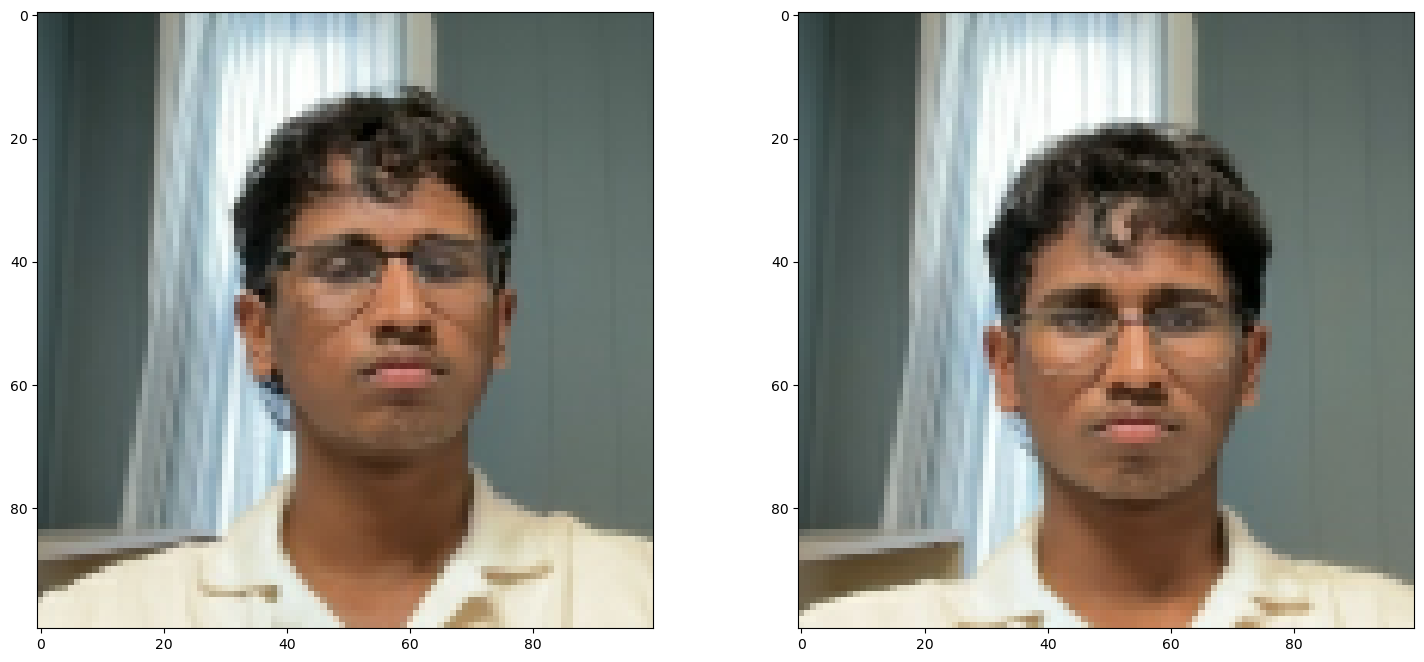

In [69]:
pito.figure(figsize=(18,8))
pito.subplot(1,2,1)
pito.imshow(test_input[1])
pito.subplot(1,2,2)
pito.imshow(test_val[1])
pito.show()



In [143]:
siamese_model.save('siamesemodelv2.h5') #already ran

In [144]:
model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [145]:
model.predict([test_input, test_val]) #reloaded model predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


array([[9.81013873e-04],
       [9.19383824e-01],
       [7.72338331e-01],
       [4.89635050e-01],
       [8.57441686e-03],
       [8.12477469e-01],
       [6.28654705e-03],
       [4.91370201e-01],
       [8.38319838e-01],
       [4.84309465e-01],
       [9.59350348e-01],
       [3.24850716e-02],
       [2.59448029e-03],
       [6.39530539e-04],
       [5.44198696e-03],
       [1.33548025e-02]], dtype=float32)

In [146]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [109]:
#Real Time verification

cap = cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[80:80+250, 160:160+250, :]

    cv2.imshow('Verification', frame)

    #Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

        #Verification Function
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

In [110]:
results

[array([[0.16720714]], dtype=float32),
 array([[0.1287595]], dtype=float32),
 array([[0.06367529]], dtype=float32),
 array([[0.00302716]], dtype=float32),
 array([[0.26542506]], dtype=float32),
 array([[0.00020973]], dtype=float32),
 array([[0.01717714]], dtype=float32),
 array([[0.22857603]], dtype=float32),
 array([[0.04057695]], dtype=float32),
 array([[0.20364706]], dtype=float32),
 array([[0.12938586]], dtype=float32),
 array([[0.14739452]], dtype=float32),
 array([[0.03098423]], dtype=float32),
 array([[0.05196243]], dtype=float32),
 array([[0.02598155]], dtype=float32),
 array([[0.0045304]], dtype=float32),
 array([[0.18673782]], dtype=float32),
 array([[0.00055689]], dtype=float32),
 array([[0.0044505]], dtype=float32),
 array([[0.16141757]], dtype=float32),
 array([[0.15668632]], dtype=float32),
 array([[0.23478879]], dtype=float32),
 array([[0.02041028]], dtype=float32),
 array([[0.00934944]], dtype=float32),
 array([[0.16727939]], dtype=float32),
 array([[0.00046449]], dtype

In [114]:
np.squeeze(results) > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])